# 19th August 2025 
# Peace Bekee
# Machine Learning Project

## Setting Working Environment

In [315]:
import pandas as pd #this is to manipulate the data
import requests
import pandas as pd
!pip install biopython
from Bio import Entrez
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, shapiro, pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import ast  # to safely parse stringified lists
import os

## API Access


In [213]:
BASE_URL = "https://www.cbioportal.org/api"            # Base for API request                
HEADERS = {"accept": "application/json", "Content-Type": "application/json"}   #jsom formatted data

study_id = "prad_tcga_pan_can_atlas_2018"                     #study identifier
sample_list_id = "prad_tcga_pan_can_atlas_2018_all"           # list of sample identifier

# GET SAMPLE ID
samples_url = f"{BASE_URL}/sample-lists/{sample_list_id}"     #retrieve sample list 
samples_resp = requests.get(samples_url, headers=HEADERS)     #send request to the url
samples_resp.raise_for_status()                               #checck if request is successful
sample_ids = samples_resp.json().get("sampleIds", [])         #extracts the sample ID
print(f" Found {len(sample_ids)} samples in {sample_list_id}")

 Found 494 samples in prad_tcga_pan_can_atlas_2018_all


In [216]:
# Converting HUGO → Entrez IDs via Bio-python
def get_entrez_ids_biopython(hugo_list):    #define a function   
    entrez_ids = {}                         #create empty dictionary to store
    for gene in hugo_list:                  #iterate through the gene symbol list
        handle = Entrez.esearch(db="gene", term=f"{gene}[Gene Name] AND Homo sapiens[Organism]")   #search query against NCBI database
        record = Entrez.read(handle)        #reads the search0
        handle.close()                      #close ncbi connection
        if record["IdList"]:                # if an ID is found
            entrez_ids[gene] = int(record["IdList"][0]) #convert the first one to an integer and store as entrez ID
        else:
            entrez_ids[gene] = None
            print(f"No match found for {gene}")
    return entrez_ids

# MAPK pathway genes
hugo_genes = [
    "EGFR","KRAS","HRAS","NRAS",
    "ARAF","BRAF","RAF1",
    "MAP2K1","MAP2K2",
    "MAPK1","MAPK3",
    "KSR1","KSR2"
]
entrez_map = get_entrez_ids_biopython(hugo_genes)          #Call function
entrez_ids = [eid for eid in entrez_map.values() if eid is not None]        
print("Converted HUGO → Entrez IDs:", entrez_map)




C:\Users\peace\anaconda3\Lib\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


Converted HUGO → Entrez IDs: {'EGFR': 1956, 'KRAS': 3845, 'HRAS': 3265, 'NRAS': 4893, 'ARAF': 369, 'BRAF': 673, 'RAF1': 5894, 'MAP2K1': 5604, 'MAP2K2': 5605, 'MAPK1': 5594, 'MAPK3': 5595, 'KSR1': 8844, 'KSR2': 22866}


In [218]:
#  Molecular profiles 
molecular_profiles = {
    "cna_log2": "prad_tcga_pan_can_atlas_2018_log2CNA",
    "mrna": "prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna",
    "mrna_zscores": "prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna_median_all_sample_Zscores"
}
#create a dictionary for  moleculat value.

# Molecular data
def fetch_molecular_data(profile_id, samples, entrez_ids):               #function to get molecular data
    url = f"{BASE_URL}/molecular-profiles/{profile_id}/molecular-data/fetch"       #url for cBioportal API to get molecular data 
    payload = {"entrezGeneIds": entrez_ids, "sampleIds": samples}         #Dictionary to know ganes and samples i need data
    resp = requests.post(url, headers=HEADERS, json=payload)              #Post requestfor the gene and sample ID
    if resp.status_code == 200:
        df = pd.DataFrame(resp.json())                                   #convert to a dataframe using pandas 
        print(f"Retrieved {df.shape[0]} rows from {profile_id}")          
        return df
    else:
        print(f" Error fetching {profile_id}: {resp.status_code}")
        print(resp.text)
        return pd.DataFrame()

molecular_dfs = {}                    #Create dictionary to store dataframe
for name, profile_id in molecular_profiles.items():      # iterate through the name cna, mrna
    df = fetch_molecular_data(profile_id, sample_ids, entrez_ids)
    molecular_dfs[name] = df
    if not df.empty:
        df.to_csv(f"{name}.csv", index=False)
        print(f"Saved {name}.csv")


timeline_url = f"{BASE_URL}/studies/{study_id}/clinical-events"
timeline_resp = requests.get(timeline_url, headers=HEADERS)
if timeline_resp.status_code == 200:
    df_timeline = pd.DataFrame(timeline_resp.json())
    print(f" Retrieved {df_timeline.shape[0]} treatment timeline events")
    print("Timeline columns:", list(df_timeline.columns))
    df_timeline.to_csv(f"{study_id}_treatment_timeline.csv", index=False)
    print(f"Saved {study_id}_treatment_timeline.csv")
else:
    print("Error fetching timeline:", timeline_resp.status_code, timeline_resp.text)


clinical_url = f"{BASE_URL}/studies/{study_id}/clinical-data"
clinical_resp = requests.get(clinical_url, headers=HEADERS)
if clinical_resp.status_code == 200:
    df_clinical = pd.DataFrame(clinical_resp.json())
    print(f" Retrieved {df_clinical.shape[0]} patients, {df_clinical.shape[1]} columns")
    print(" Clinical columns:", list(df_clinical.columns))
    df_clinical.to_csv(f"{study_id}_clinical_data.csv", index=False)
    print(f"Saved FULL {study_id}_clinical_data.csv")
else:
    print("Error fetching clinical data:", clinical_resp.status_code, clinical_resp.text)

print("- cna_log2.csv")
print("- mrna.csv")
print("- mrna_zscores.csv")
print(f"- {study_id}_treatment_timeline.csv")
print(f"- {study_id}_clinical_data.csv")


Retrieved 6357 rows from prad_tcga_pan_can_atlas_2018_log2CNA
Saved cna_log2.csv
Retrieved 6409 rows from prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna
Saved mrna.csv
Retrieved 6409 rows from prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna_median_all_sample_Zscores
Saved mrna_zscores.csv
 Retrieved 2262 treatment timeline events
Timeline columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'attributes', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis']
Saved prad_tcga_pan_can_atlas_2018_treatment_timeline.csv
 Retrieved 8854 patients, 7 columns
 Clinical columns: ['uniqueSampleKey', 'uniquePatientKey', 'sampleId', 'patientId', 'studyId', 'clinicalAttributeId', 'value']
Saved FULL prad_tcga_pan_can_atlas_2018_clinical_data.csv
- cna_log2.csv
- mrna.csv
- mrna_zscores.csv
- prad_tcga_pan_can_atlas_2018_treatment_timeline.csv
- prad_tcga_pan_can_atlas_2018_clinical_data.csv


## Identification of Gene and Treatment Data

In [220]:
cna_df=pd.read_csv("cna_log2.csv")
mrna_df=pd.read_csv("mrna_zscores.csv")
clinical_df=pd.read_csv("prad_tcga_pan_can_atlas_2018_clinical_data.csv")

#saving to working Directory as CSV
#cna_df.to_csv("cna_log2.csv", index=False)
#mrna_df.to_csv("mrna_zscores.csv", index=False)
#clinical_df.to_csv("prad_tcga_pan_can_atlas_2018_clinical_data.csv", index=False)

# Saving to working directory as Excel
#cna_df.to_excel("cna_log2.xlsx", index=False)
#mrna_df.to_excel("mrna_zscores.xlsx", index=False)
#clinical_df.to_excel("prad_tcga_pan_can_atlas_2018_clinical_data.xlsx", index=False)

In [222]:
# all the columns in clinical df
print(clinical_df.columns)

Index(['uniqueSampleKey', 'uniquePatientKey', 'sampleId', 'patientId',
       'studyId', 'clinicalAttributeId', 'value'],
      dtype='object')


In [224]:
# Loading the  treatment timeline data
treatment_df = pd.read_csv("prad_tcga_pan_can_atlas_2018_treatment_timeline.csv")

print("Loaded timeline shape:", treatment_df.shape)
print("Current columns:", treatment_df.columns.tolist())


Loaded timeline shape: (2262, 7)
Current columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'attributes', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis']


In [231]:
# Loading the  treatment timeline data
treatment_df = pd.read_csv("prad_tcga_pan_can_atlas_2018_treatment_timeline.csv")

print("Loaded timeline shape:", treatment_df.shape)
print("Current columns:", treatment_df.columns.tolist())

# Function to flatten attributes 
def flatten_timeline(df):
    expanded_rows = []

    for _, row in df.iterrows():
        base_data = row.drop("attributes").to_dict() #all other columns

        #parse the 'attributes' column (its stored as a sting in csv)
        try:
            attr_list = ast.literal_eval(row["attributes"]) if pd.notna(row["attributes"]) else []
        except Exception:
            attr_list = []

        #convert list of dicts to single dict
        if isinstance(attr_list, list):
            attr_data ={attr["key"]: attr["value"] for attr in attr_list}
        else:
            attr_data = {}

        #combine base + expanded attributes 
        expanded_rows.append({**base_data, **attr_data})

    return pd.DataFrame(expanded_rows)


#  Flatten it 
df_flat_timeline = flatten_timeline(treatment_df)

print(" Flattened timeline shape:", df_flat_timeline.shape)
print(" New columns:", df_flat_timeline.columns.tolist())

# Save flattened version
df_flat_timeline.to_csv("prad_tcga_pan_can_atlas_2018_treatment_timeline_flat.csv", index=False)
print(" Saved flattened version → prad_tcga_pan_can_atlas_2018_treatment_timeline_flat.csv")

df_flat_timeline.to_excel("prad_tcga_pan_can_atlas_2018_treatment_timeline_flat.xlsx", index=False)


Loaded timeline shape: (2262, 7)
Current columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'attributes', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis']
 Flattened timeline shape: (2262, 51)
 New columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis', 'SUBMITTED_FOR_LCE', 'TOP_SLIDE_SUBMITTED', 'TUMOR_NUCLEI_PERCENT', 'COUNTRY', 'METHOD_OF_SAMPLE_PROCUREMENT', 'VESSEL_USED', 'SAMPLE_PRESCREENED', 'TUMOR_WEIGHT', 'TUMOR_NECROSIS_PERCENT', 'SAMPLE_ID', 'STATUS', 'GLEASON_SECONDARY_PATTERN', 'PSA_VALUE', 'PATHOLOGIC_T', 'CLINICAL_M', 'GLEASON_SCORE', 'GLEASON_TERTIARY_PATTERN', 'GLEASON_PRIMARY_PATTERN', 'DAYS_TO_PSA', 'INITIAL_PATHOLOGIC_DIAGNOSIS_METHOD', 'PATHOLOGIC_N', 'VITAL_STATUS', 'CLINICAL_T', 'AGENT', 'TREATMENT_TYPE', 'MEASURE_OF_RESPONSE', 'TX_ON_CLINICAL_TRIAL', 'THERAPY_ONGOING', 'ANATOMIC_TREATMENT_SITE', 'RADIATION_TREATMENT_ONGOING', 'RADIATION_TYPE', 'RADIA

In [229]:
def entrez_to_hugo_biopython(entrez_ids):
    mapping = {}
    for eid in entrez_ids:
        try:
            handle = Entrez.esummary(db="gene", id=str(eid))
            record = Entrez.read(handle)
            handle.close()

            if record and "DocumentSummarySet" in record:
                docs = record["DocumentSummarySet"]["DocumentSummary"]
                if docs:
                    mapping[eid] = docs[0]["NomenclatureSymbol"]  # HUGO symbol
        except Exception as e:
            print(f"Could not fetch for {eid}: {e}")
    return mapping

# Get unique Entrez IDs from your data
unique_entrez_ids = mrna_df["entrezGeneId"].unique().tolist()

# Fetch mapping
entrez_to_hugo_map = entrez_to_hugo_biopython(unique_entrez_ids)

print(f" Retrieved {len(entrez_to_hugo_map)} gene symbols")


C:\Users\peace\anaconda3\Lib\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


 Retrieved 13 gene symbols


In [234]:
#Mrna df
mrna_df["hugoGeneSymbol"] = mrna_df["entrezGeneId"].map(entrez_to_hugo_map)

# Reorder columns for readability
cols = ["hugoGeneSymbol", "entrezGeneId"] + [c for c in mrna_df.columns if c not in ["hugoGeneSymbol", "entrezGeneId"]]
mrna_df = mrna_df[cols]
mrna_df.head()

cna_df["hugoGeneSymbol"] = cna_df["entrezGeneId"].map(entrez_to_hugo_map)

# Reorder columns for readability
cols = ["hugoGeneSymbol", "entrezGeneId"] + [c for c in mrna_df.columns if c not in ["hugoGeneSymbol", "entrezGeneId"]]
cna_df = cna_df[cols]
cna_df.head()



,hugoGeneSymbol,entrezGeneId,uniqueSampleKey,uniquePatientKey,molecularProfileId,sampleId,patientId,studyId,value
0,ARAF,369,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,-0.016
1,BRAF,673,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.001
2,EGFR,1956,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.001
3,HRAS,3265,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.010
4,KRAS,3845,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.001


In [236]:
# Transpose mRNA
mrna_trans_df = (
    mrna_df
    .pivot(index="sampleId", columns="hugoGeneSymbol", values="value")  # reshape long → wide
    .reset_index()
    .rename(columns={"sampleId": "Sample_ID"})
)
# Add patient-level ID
mrna_trans_df["PATIENT_ID"] = mrna_trans_df["Sample_ID"].str[:12]

print("Transposed mRNA shape:", mrna_trans_df.shape)

# Transpose CNA
cna_trans_df = (
    cna_df
    .pivot(index="sampleId", columns="hugoGeneSymbol", values="value")
    .reset_index()
    .rename(columns={"sampleId": "Sample_ID"})
)

# Add patient-level ID
cna_trans_df["PATIENT_ID"] = cna_trans_df["Sample_ID"].str[:12]

#  Rename gene columns → GENE_CNA
gene_cols = [col for col in cna_trans_df.columns if col not in ["Sample_ID", "PATIENT_ID"]]
cna_trans_df.rename(columns={g: f"{g}_CNA" for g in gene_cols}, inplace=True)

print(" Transposed CNA shape:", cna_trans_df.shape)
print("Example CNA columns:", list(cna_trans_df.columns)[:10])

# Save transposed dataframes to CSV
mrna_trans_df.to_csv("mrna_transposed.csv", index=False)
cna_trans_df.to_csv("cna_transposed.csv", index=False)

# Save transposed dataframes to Excel
# mrna_trans_df.to_excel("mrna_transposed.xlsx", index=False)
# cna_trans_df.to_excel("cna_transposed.xlsx", index=False)


Transposed mRNA shape: (493, 15)
 Transposed CNA shape: (489, 15)
Example CNA columns: ['Sample_ID', 'ARAF_CNA', 'BRAF_CNA', 'CNKSR2_CNA', 'EGFR_CNA', 'HRAS_CNA', 'KRAS_CNA', 'KSR1_CNA', 'MAP2K1_CNA', 'MAP2K2_CNA']


In [238]:
cna_trans_df.head()

hugoGeneSymbol,Sample_ID,ARAF_CNA,BRAF_CNA,CNKSR2_CNA,EGFR_CNA,HRAS_CNA,KRAS_CNA,KSR1_CNA,MAP2K1_CNA,MAP2K2_CNA,MAPK1_CNA,MAPK3_CNA,NRAS_CNA,RAF1_CNA,PATIENT_ID
0,TCGA-2A-A8VL-01,-0.016,0.001,-0.016,0.001,0.010,0.001,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,TCGA-2A-A8VL
1,TCGA-2A-A8VO-01,-0.015,0.002,-0.015,0.002,0.000,-0.002,0.005,0.004,0.004,0.009,0.010,0.002,0.005,TCGA-2A-A8VO
2,TCGA-2A-A8VT-01,-0.097,0.061,-0.097,0.063,0.076,-0.690,-0.252,-0.025,0.013,-0.369,0.056,0.046,0.059,TCGA-2A-A8VT
3,TCGA-2A-A8VV-01,-0.003,0.002,-0.016,0.002,0.000,0.000,0.001,0.003,0.009,0.010,0.006,-0.001,0.004,TCGA-2A-A8VV
4,TCGA-2A-A8VX-01,-0.041,0.081,-0.027,0.079,-0.002,0.001,-0.017,-0.011,-0.022,-0.024,-0.016,-0.010,0.026,TCGA-2A-A8VX


## Preparing The Target Dataset


In [247]:
#Extract target dataframe and rename patientId to PATIENT_ID
target_df = df_flat_timeline[['patientId', 'MEASURE_OF_RESPONSE', 'TREATMENT_TYPE', 'AGENT']].rename(
    columns = {"patientId": "PATIENT_ID"}
)
print(target_df.columns.tolist())
print("Target dataframe shape:", target_df.shape)

#saving to working directory
#target_df.to_excel("target_df.xlsx", index=False)

['PATIENT_ID', 'MEASURE_OF_RESPONSE', 'TREATMENT_TYPE', 'AGENT']
Target dataframe shape: (2262, 4)


## Join Operation on MAPK Gene and Response Variable
To prepare the data set for machine learning, the data was joined 

In [259]:
#  Merging transposed mRNA & CNA on PATIENT_ID
omics_combined = mrna_trans_df.merge(
    cna_trans_df,
    on='PATIENT_ID',
    how='inner'
)
print("After merging mRNA + CNA:", omics_combined.shape)

# Merging with treatment response target_df
final_merged_df = omics_combined.merge(
    target_df,
    on='PATIENT_ID',
    how='inner'
)
print("Final merged shape (omics + response):", final_merged_df.shape)


print(final_merged_df.head())

final_merged_df.to_csv('final_merged_df.csv', index=False)
print("Saved final_merged_df.csv")

final_merged_df.to_excel('final_merged_df.xlsx', index=False)

After merging mRNA + CNA: (488, 29)
Final merged shape (omics + response): (2231, 32)
       Sample_ID_x   ARAF    BRAF  CNKSR2    EGFR    HRAS    KRAS    KSR1  \
0  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
1  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
2  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
3  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
4  TCGA-2A-A8VO-01  0.846 -1.1840  0.2777 -1.2636  0.7671 -0.3870 -0.6894   

   MAP2K1  MAP2K2  ...  KSR1_CNA  MAP2K1_CNA  MAP2K2_CNA  MAPK1_CNA MAPK3_CNA  \
0  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
1  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
2  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
3  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
4  0.7794  1.1497  ...     0.005       0.004  

## Importing Dataset To Environment From Working Directory

In [261]:
df = pd.read_csv('final_merged_df.csv')
print(" Merged DataFrame shape:", df.shape)
df.head()

 Merged DataFrame shape: (2231, 32)


,Sample_ID_x,ARAF,BRAF,CNKSR2,EGFR,HRAS,KRAS,KSR1,MAP2K1,MAP2K2,...,KSR1_CNA,MAP2K1_CNA,MAP2K2_CNA,MAPK1_CNA,MAPK3_CNA,NRAS_CNA,RAF1_CNA,MEASURE_OF_RESPONSE,TREATMENT_TYPE,AGENT
0,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
1,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
2,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
3,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
4,TCGA-2A-A8VO-01,0.846,-1.1840,0.2777,-1.2636,0.7671,-0.3870,-0.6894,0.7794,1.1497,...,0.005,0.004,0.004,0.009,0.010,0.002,0.005,NaN,NaN,NaN


## Wrangle Function 
To clean the merged data frame. 

In [264]:
def wrangler(data):
    """
    Cleans the merged DataFrame for ML:
    - Drops rows with missing MEASURE_OF_RESPONSE
    - Maps MEASURE_OF_RESPONSE into 'Responsive' and 'Resistant'
    - Drops ID columns (PATIENT_ID, Sample_ID_x, Sample_ID_y)
    - Resets index to avoid misalignment issues
    Returns the cleaned DataFrame ready for training.
    """

    # Drop rows with missing response
    data = data.dropna(subset=['MEASURE_OF_RESPONSE']).copy()

    # Map to binary response classes
    response_map = {
        'complete response': 'Responsive',
        'partial response': 'Responsive',
        'stable disease': 'Resistant',
        'clinical progressive disease': 'Resistant',
        'radiographic progressive disease': 'Resistant'
    }
    data['MEASURE_OF_RESPONSE'] = data['MEASURE_OF_RESPONSE'].replace(response_map)

    #  Drop ID columns if present
    id_cols_to_drop = [col for col in ['PATIENT_ID', 'Sample_ID_x', 'Sample_ID_y'] if col in data.columns]
    data = data.drop(columns=id_cols_to_drop)

    #  Reset index (important for sklearn training)
    data.reset_index(drop=True, inplace=True)

    print(f" Cleaned data shape: {data.shape}")
    print(" Response class counts:\n", data['MEASURE_OF_RESPONSE'].value_counts())

    return data


In [266]:
# Clean the data using wrangler function
df_clean = wrangler(df)

# Display the shape of the cleaned DataFrame
print("Cleaned DataFrame shape:", df_clean.shape)

# Preview the first few rows
df_clean.head()

 Cleaned data shape: (131, 29)
 Response class counts:
 MEASURE_OF_RESPONSE
Responsive    98
Resistant     33
Name: count, dtype: int64
Cleaned DataFrame shape: (131, 29)


,ARAF,BRAF,CNKSR2,EGFR,HRAS,KRAS,KSR1,MAP2K1,MAP2K2,MAPK1,...,KSR1_CNA,MAP2K1_CNA,MAP2K2_CNA,MAPK1_CNA,MAPK3_CNA,NRAS_CNA,RAF1_CNA,MEASURE_OF_RESPONSE,TREATMENT_TYPE,AGENT
0,-0.2260,1.1105,-0.9779,0.7586,0.1345,-1.3060,0.1553,1.2351,-0.4458,-0.4918,...,-0.252,-0.025,0.013,-0.369,0.056,0.046,0.059,Resistant,Hormone Therapy,Leuprolide
1,-0.2260,1.1105,-0.9779,0.7586,0.1345,-1.3060,0.1553,1.2351,-0.4458,-0.4918,...,-0.252,-0.025,0.013,-0.369,0.056,0.046,0.059,Resistant,Radiation Therapy,Radiation 1
2,-0.0553,-0.1687,-1.5081,-0.5837,-0.5289,-0.0316,-1.6082,0.9456,-0.8248,-0.8615,...,-0.014,0.006,-0.015,-0.008,-0.018,0.002,-0.003,Responsive,Hormone Therapy,Leuprolide
3,-1.5351,1.9882,2.0072,1.4343,-1.4200,1.5574,-1.7267,-0.0737,-3.2238,0.5970,...,-0.062,0.002,-0.782,-0.016,0.004,0.003,-0.007,Resistant,Hormone Therapy,Triptorelin
4,-1.1922,1.1519,0.3031,1.0609,-1.3305,2.6857,0.2714,0.3820,-1.9529,1.6209,...,-0.390,0.013,-0.026,0.029,-0.059,-0.004,-0.009,Resistant,Radiation Therapy,Radiation 1


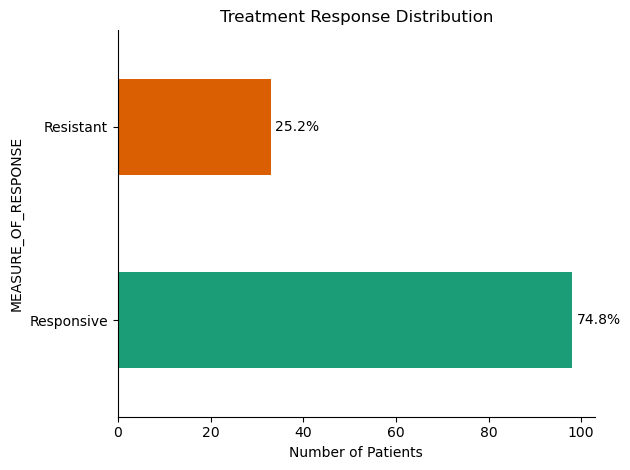

In [270]:
# Count the response categories
counts = df_clean['MEASURE_OF_RESPONSE'].value_counts()
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Create the barh plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind='barh', color=colors)

# Add percentage labels next to each bar
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

# Clean up plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("Treatment Response Distribution")
plt.tight_layout()
plt.show()

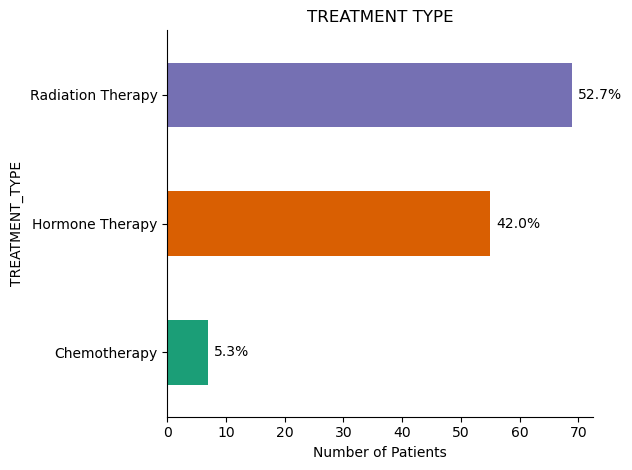

In [272]:
# Count the response categories
counts = df_clean['TREATMENT_TYPE'].value_counts().sort_values(ascending=True)
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Create the barh plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind='barh', color=colors)

# Add percentage labels next to each bar
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

# Clean up plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("TREATMENT TYPE")
plt.tight_layout()
plt.show()

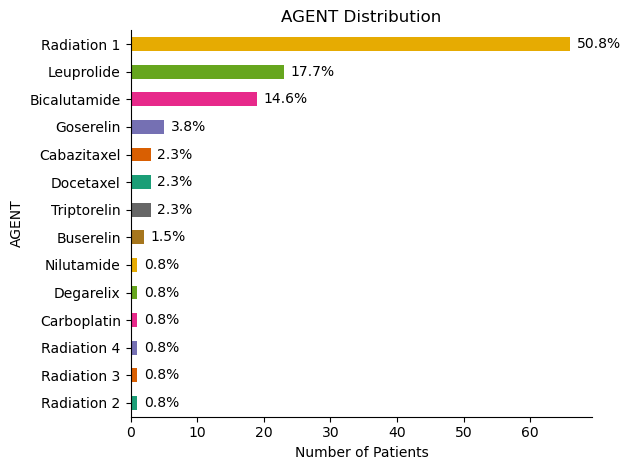

In [274]:
counts = df_clean['AGENT'].value_counts().sort_values(ascending=True)
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Create the barh plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind='barh', color=colors)

# Add percentage labels next to each bar
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

# Clean up plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("AGENT Distribution")
plt.tight_layout()
plt.show()

C:\Users\peace\AppData\Local\Temp\ipykernel_22808\143239259.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='MEASURE_OF_RESPONSE', data=df_clean, palette='viridis')  #create barchart with seaborn


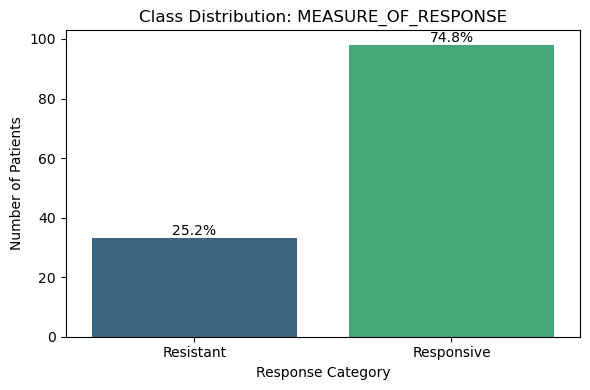

In [276]:
#Check Class Balance

# Calculate value counts and percentages
response_counts = df_clean['MEASURE_OF_RESPONSE'].value_counts()           #counts num times labels appear in column
response_percent = (response_counts / response_counts.sum()) * 100

# Plot
plt.figure(figsize=(6, 4))                                         #set plot size
ax = sns.countplot(x='MEASURE_OF_RESPONSE', data=df_clean, palette='viridis')  #create barchart with seaborn  

# Add percentage labels on bars
for p in ax.patches:                                      #iterate through each bar
    height = p.get_height()                               #number of samples in the label
    percent = (height / len(df_clean)) * 100           
    ax.annotate(f'{percent:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.title('Class Distribution: MEASURE_OF_RESPONSE')
plt.xlabel('Response Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## mRNA and CNA
### Declaring Feature and Target (Train,Validate and Test)

In [280]:

# Define predictors and target
X = df_clean.drop(['MEASURE_OF_RESPONSE', 'TREATMENT_TYPE', 'AGENT'], axis=1) #remove non-use predictor
y = df_clean['MEASURE_OF_RESPONSE']

# First split: Train (80%), Temp (20%),  stratify for imbalanced data 
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: Validation (10%), Test (10%) from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Check proportions
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

print("\nTrain distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation distribution:\n", y_val.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))


Train shape: (104, 26)
Validation shape: (13, 26)
Test shape: (14, 26)

Train distribution:
 MEASURE_OF_RESPONSE
Responsive    0.75
Resistant     0.25
Name: proportion, dtype: float64

Validation distribution:
 MEASURE_OF_RESPONSE
Responsive    0.769231
Resistant     0.230769
Name: proportion, dtype: float64

Test distribution:
 MEASURE_OF_RESPONSE
Responsive    0.714286
Resistant     0.285714
Name: proportion, dtype: float64


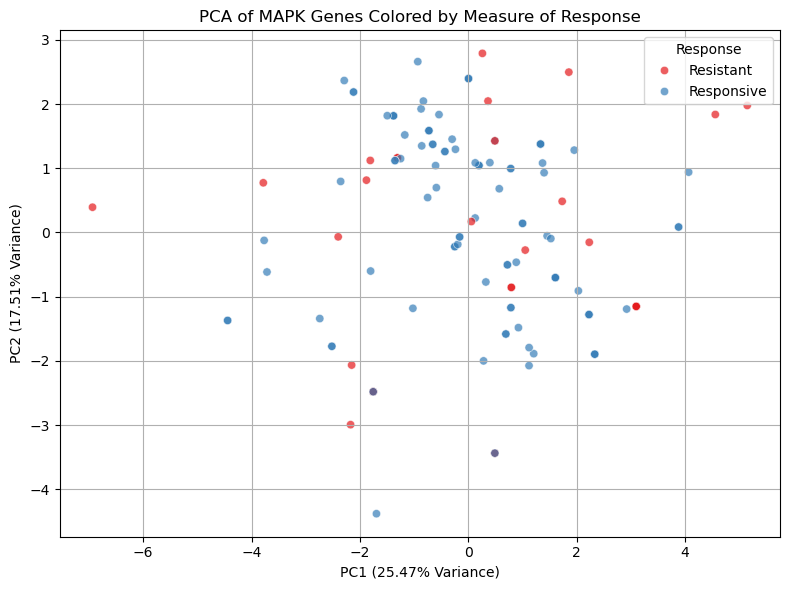

In [282]:

X_mapk = X  # assuming X is already log-transformed and z-scored

# Apply PCA directly
pca = PCA(n_components=2)                   #set to produce 2 components 
X_pca = pca.fit_transform(X_mapk)           #transform data to 2D 

#  Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])   
pca_df['Response'] = df_clean['MEASURE_OF_RESPONSE']  #create response column to hold labels 

#  Creates scatterPlot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Response',
    palette='Set1',
    data=pca_df,
    alpha=0.7
)

plt.title('PCA of MAPK Genes Colored by Measure of Response')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')   #x-axis label with pc1total variance 
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.grid(True)
plt.tight_layout()  #adjust plot spacing
plt.show()

In [284]:
print(pca.explained_variance_ratio_)

[0.25470893 0.17507909]


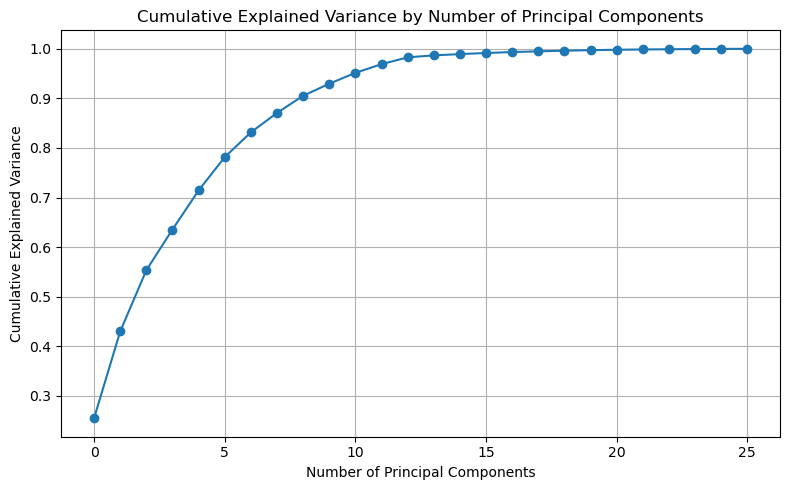

In [286]:
# Fit PCA with more components
pca_full = PCA().fit(X_mapk)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


### Pipeline

In [288]:
#randomforest pipeline, account for reproducibility and class imbalance 
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}

# Perform grid search cross-validation on the pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,          #hyperparameters
    cv=5,                           #5fold cross validation 
    scoring='accuracy',             #accuracy as evaluation 
    n_jobs=-1,
    verbose=2,
    return_train_score=True        #return training scores          
)

# Fit directly  this pipeline + best model = final model
grid_search.fit(X_train, y_train)

# The best model is ready and stored in grid_search.best_estimator_
final_model = grid_search.best_estimator_

# Fit the model on the training set
final_model.fit(X_train, y_train)

# Display the best parameters and cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Cross-Validation Score: 0.8261904761904763


Validation Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

   Resistant       1.00      0.67      0.80         3
  Responsive       0.91      1.00      0.95        10

    accuracy                           0.92        13
   macro avg       0.95      0.83      0.88        13
weighted avg       0.93      0.92      0.92        13



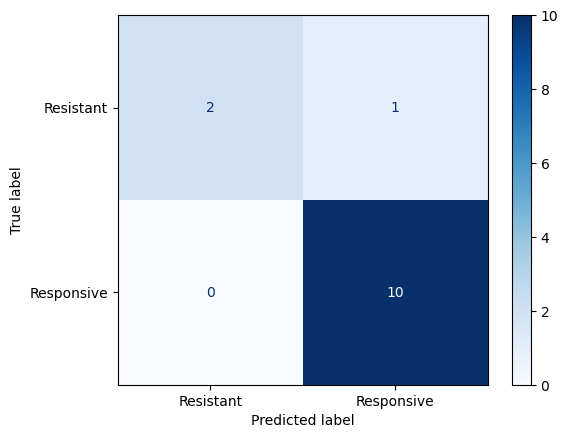

In [291]:
val_preds = final_model.predict(X_val)           #generate predictions with trained model on the validation data

# Print accuracy and classification report
print("Validation Accuracy:", accuracy_score(y_val, val_preds))       # Print accuracy on the validation data 
print(classification_report(y_val, val_preds))                        #print other classification metrices

# Generate and display the confusion matrix
cm = confusion_matrix(y_val, val_preds)              # confusion matrix to compare true labels with predicted labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues', values_format='d')          # plot the confusion matrix  #display integer counts 

Test Accuracy (ACC): 0.7857142857142857

Tuned Classification Report:
              precision    recall  f1-score   support

   Resistant       1.00      0.25      0.40         4
  Responsive       0.77      1.00      0.87        10

    accuracy                           0.79        14
   macro avg       0.88      0.62      0.63        14
weighted avg       0.84      0.79      0.74        14

Confusion matrix

 [[ 1  3]
 [ 0 10]]


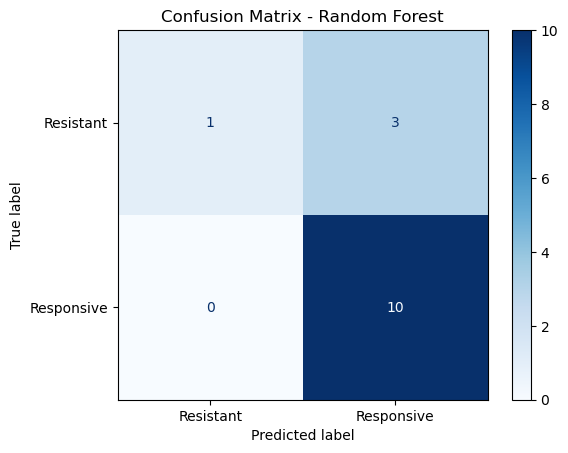

In [309]:

# Predict on the test set using the fitted model
y_pred = final_model.predict(X_test)

# Calculate test accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy (ACC):", acc)

# Display the tuned classification report
print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

cm = confusion_matrix(y_test, y_pred, labels=['Resistant', 'Responsive'])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Resistant', 'Responsive'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

Test AUC: 0.8500000000000001


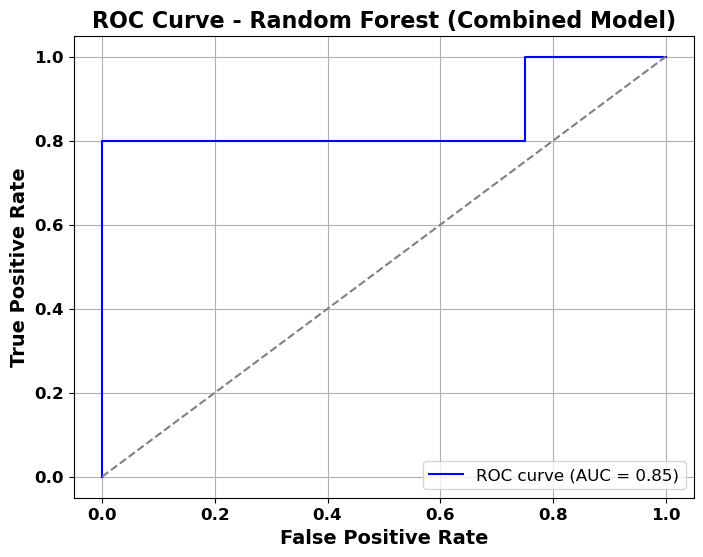

In [345]:
# Predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]  # 'Responsive' as positive

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)
print("Test AUC:", auc_score)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Responsive')

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Customize ticks to be bold and black
plt.xticks(fontsize=12, fontweight='bold', color='black')
plt.yticks(fontsize=12, fontweight='bold', color='black')

plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', color='black')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', color='black')
plt.title('ROC Curve - Random Forest (Combined Model)', fontsize=16, fontweight='bold', color='black')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

## mRNA


This stage involves training a Random Forest classification model using only the mRNA expression features from the dataset. The objective is to isolate the predictive capacity of transcriptomic data in identifying treatment response. By excluding CNV and mutation data, the model will assess how well gene expression alone captures meaningful biological patterns, while maintaining interpretability and reducing potential noise from other molecular layers.

In [372]:
def wrangler_mra(data):
    """
    Cleans the merged DataFrame for ML:
    - Drops rows with missing MEASURE_OF_RESPONSE
    - Maps MEASURE_OF_RESPONSE into 'Responsive' and 'Resistant'
    - Drops ID columns (PATIENT_ID, Sample_ID_x, Sample_ID_y)
    - Drops all columns ending with 'cna' (to retain only mRNA features)
    - Resets index to avoid misalignment issues
    Returns the cleaned DataFrame ready for training.
    """

    # Drop rows with missing response
    data = data.dropna(subset=['MEASURE_OF_RESPONSE']).copy()

    # Map to binary response classes
    response_map = {
        'complete response': 'Responsive',
        'partial response': 'Responsive',
        'stable disease': 'Resistant',
        'clinical progressive disease': 'Resistant',
        'radiographic progressive disease': 'Resistant'
    }
    data['MEASURE_OF_RESPONSE'] = data['MEASURE_OF_RESPONSE'].replace(response_map)

    # Drop ID columns if present
    id_cols_to_drop = [col for col in ['PATIENT_ID', 'Sample_ID_x', 'Sample_ID_y'] if col in data.columns]
    data = data.drop(columns=id_cols_to_drop)

    # Drop all columns ending with 'cna' (to retain only mRNA features)
    cna_cols_to_drop = [col for col in data.columns if col.lower().endswith('cna')]
    data = data.drop(columns=cna_cols_to_drop)

    # Reset index
    data.reset_index(drop=True, inplace=True)

    print(f"Cleaned data shape: {data.shape}")
    print("Response class counts:\n", data['MEASURE_OF_RESPONSE'].value_counts())

    return data

# Clean the data using wrangler function
df_mrna = wrangler_mra(df_clean)
# Display the shape of the cleaned DataFrame
print("Cleaned DataFrame shape:", df_mrna.shape)

# the first few rows
df_mrna.head()

# duplicating for statistical analysis
mrna_copy=df_mrna.copy()
mrna_copy.to_csv('mrna_copy.csv', index=False)
print("Saved mrna_copy.csv")
mrna_copy.to_excel('mrna_copy.xlsx', index=False)

Cleaned data shape: (131, 16)
Response class counts:
 MEASURE_OF_RESPONSE
Responsive    98
Resistant     33
Name: count, dtype: int64
Cleaned DataFrame shape: (131, 16)
Saved mrna_copy.csv


### mRNA Statistical Analysis
this section presents the statistical analysis of the mRNA dataset and its relation to the measure of response (resistant and non-resistant)


C:\Users\peace\AppData\Local\Temp\ipykernel_22808\3000136921.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


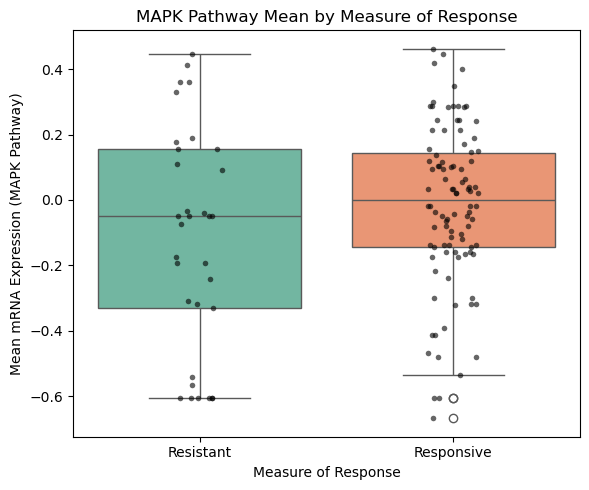

Mann–Whitney U test between 'Resistant' and 'Responsive':
  Group 1 mean = -0.123, median = -0.050, n = 33
  Group 2 mean = -0.018, median = 0.001, n = 98
  U = 1316.500, p = 1.116e-01


In [405]:
gene_cols = [
    "ARAF", "BRAF", "CNKSR2", "EGFR", "HRAS", "KRAS", "KSR1",
    "MAP2K1", "MAP2K2", "MAPK1", "MAPK3", "NRAS", "RAF1"
]

numeric_gene_cols = [g for g in gene_cols if pd.api.types.is_numeric_dtype(mrna_copy[g])]   #iterate through the genes, for only numeric values 

# Calculate row-wise mean for MAPK pathway
mrna_copy["MAPK_mean"] = mrna_copy[numeric_gene_cols].mean(axis=1)    

# Group comparison between response categories
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=mrna_copy,
    x="MEASURE_OF_RESPONSE",
    y="MAPK_mean",
    palette="Set2"
)
sns.stripplot(
    data=mrna_copy,
    x="MEASURE_OF_RESPONSE",
    y="MAPK_mean",
    color="black",
    size=4,
    jitter=True,
    alpha=0.6
)
plt.title("MAPK Pathway Mean by Measure of Response")
plt.xlabel("Measure of Response")
plt.ylabel("Mean mRNA Expression (MAPK Pathway)")
plt.tight_layout()
plt.show()

if mrna_copy["MEASURE_OF_RESPONSE"].nunique() == 2:
    # Ensure consistent ordering
    categories = sorted(mrna_copy["MEASURE_OF_RESPONSE"].unique())
    group1_label, group2_label = categories

    group1 = mrna_copy.loc[mrna_copy["MEASURE_OF_RESPONSE"] == group1_label, "MAPK_mean"]
    group2 = mrna_copy.loc[mrna_copy["MEASURE_OF_RESPONSE"] == group2_label, "MAPK_mean"]

    # Mann–Whitney U test (non-parametric)
    u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')

    print(f"Mann–Whitney U test between '{group1_label}' and '{group2_label}':")
    print(f"  Group 1 mean = {group1.mean():.3f}, median = {group1.median():.3f}, n = {len(group1)}")
    print(f"  Group 2 mean = {group2.mean():.3f}, median = {group2.median():.3f}, n = {len(group2)}")
    print(f"  U = {u_stat:.3f}, p = {p_val:.3e}")

In [408]:
# Overall normality check
stat, p = shapiro(mrna_copy["MAPK_mean"].dropna())
print(f'Shapiro-Wilk test for MAPK_mean overall: stat={stat:.3f}, p={p:.3e}')
if p > 0.05:
    print("MAPK_mean looks normally distributed overall (fail to reject H0)")
else:
    print("MAPK_mean is NOT normally distributed overall (reject H0)")

# Normality check within each response group
for category in mrna_copy['MEASURE_OF_RESPONSE'].unique():
    group_data = mrna_copy[mrna_copy['MEASURE_OF_RESPONSE'] == category]['MAPK_mean'].dropna()
    stat, p = shapiro(group_data)
    print(f'Shapiro-Wilk test for MAPK_mean in {category}: stat={stat:.3f}, p={p:.3e}')
    if p > 0.05:
        print(f"MAPK_mean in {category} looks normally distributed (fail to reject H0)")
    else:
        print(f"MAPK_mean in {category} is NOT normally distributed (reject H0)")


Shapiro-Wilk test for MAPK_mean overall: stat=0.965, p=1.963e-03
MAPK_mean is NOT normally distributed overall (reject H0)
Shapiro-Wilk test for MAPK_mean in Resistant: stat=0.927, p=2.876e-02
MAPK_mean in Resistant is NOT normally distributed (reject H0)
Shapiro-Wilk test for MAPK_mean in Responsive: stat=0.975, p=6.315e-02
MAPK_mean in Responsive looks normally distributed (fail to reject H0)


#### Cohen,d  and heidegs and rank biseral correlation

In [419]:

# Means, standard deviations, and sample sizes
mean1, mean2 = group1.mean(), group2.mean()
std1, std2 = group1.std(ddof=1), group2.std(ddof=1)
n1, n2 = len(group1), len(group2)

# Pooled standard deviation
s_pooled = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

# Cohen's d
cohen_d = (mean1 - mean2) / s_pooled

# Hedges' g
correction = 1 - (3 / (4*(n1 + n2) - 9))
hedges_g = cohen_d * correction

print(f"Cohen's d: {cohen_d:.3f}")
print(f"Hedges' g: {hedges_g:.3f}")

Cohen's d: -0.389
Hedges' g: -0.386


In [423]:
# Calculate rank-biserial correlation
n1, n2 = len(group1), len(group2)
rank_biserial = 1 - (2 * u_stat) / (n1 * n2)

print(f"Rank-biserial correlation: {rank_biserial:.3f}")


Rank-biserial correlation: 0.186


#### Gene by Gene Correlation 

In [429]:
import pandas as pd
from scipy.stats import pointbiserialr

# Encode MEASURE_OF_RESPONSE as binary: Responsive = 1, Resistant = 0
response_map = {'Resistant': 0, 'Responsive': 1}
mrna_copy['response_binary'] = mrna_copy['MEASURE_OF_RESPONSE'].map(response_map)

gene_cols = [
    "ARAF", "BRAF", "CNKSR2", "EGFR", "HRAS", "KRAS", "KSR1",
    "MAP2K1", "MAP2K2", "MAPK1", "MAPK3", "NRAS", "RAF1"
]
results = []

#loop through to calculate correlation
for gene in gene_cols:
    corr, pval = pointbiserialr(mrna_copy[gene], mrna_copy['response_binary'])
    results.append({'Gene': gene, 'Correlation': corr, 'p-value': pval})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Correlation', ascending=False)

print(results_df)

      Gene  Correlation   p-value
9    MAPK1     0.247519  0.004367
0     ARAF     0.195517  0.025222
8   MAP2K2     0.162802  0.063181
1     BRAF     0.129030  0.141885
2   CNKSR2     0.111975  0.202896
3     EGFR     0.098891  0.261111
6     KSR1     0.057341  0.515342
5     KRAS     0.024185  0.783931
10   MAPK3     0.001204  0.989109
4     HRAS    -0.010592  0.904428
7   MAP2K1    -0.052015  0.555170
12    RAF1    -0.133224  0.129274
11    NRAS    -0.165435  0.058976


In [433]:
# Define predictors and target for mRNA features only
X_mrna = df_mrna.drop(['MEASURE_OF_RESPONSE', 'TREATMENT_TYPE', 'AGENT'], axis=1)
y_mrna = df_mrna['MEASURE_OF_RESPONSE']

# First split: Train (80%), Temp (20%)
X_train_mrna, X_temp_mrna, y_train_mrna, y_temp_mrna = train_test_split(
    X_mrna, y_mrna, test_size=0.2, stratify=y_mrna, random_state=42
)

# Second split: Validation (10%), Test (10%) from Temp
X_val_mrna, X_test_mrna, y_val_mrna, y_test_mrna = train_test_split(
    X_temp_mrna, y_temp_mrna, test_size=0.5, stratify=y_temp_mrna, random_state=42
)

# Check dataset shapes
print("Train shape:", X_train_mrna.shape)
print("Validation shape:", X_val_mrna.shape)
print("Test shape:", X_test_mrna.shape)

# Check class distributions
print("\nTrain distribution:\n", y_train_mrna.value_counts(normalize=True))
print("\nValidation distribution:\n", y_val_mrna.value_counts(normalize=True))
print("\nTest distribution:\n", y_test_mrna.value_counts(normalize=True))


Train shape: (104, 13)
Validation shape: (13, 13)
Test shape: (14, 13)

Train distribution:
 MEASURE_OF_RESPONSE
Responsive    0.75
Resistant     0.25
Name: proportion, dtype: float64

Validation distribution:
 MEASURE_OF_RESPONSE
Responsive    0.769231
Resistant     0.230769
Name: proportion, dtype: float64

Test distribution:
 MEASURE_OF_RESPONSE
Responsive    0.714286
Resistant     0.285714
Name: proportion, dtype: float64


In [441]:

# 1) Pipeline
pipeline_mrna = Pipeline([
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

# 2) Hyperparameter grid
param_grid_mrna = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}

# 3) Grid search (refit=True ensures best model is retrained on full training set)
grid_search_mrna = GridSearchCV(
    estimator=pipeline_mrna,
    param_grid=param_grid_mrna,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit=True
)

# 4) Fit grid search on training data
grid_search_mrna.fit(X_train_mrna, y_train_mrna)

# 5) Retrieve the tuned model
final_model_mrna = grid_search_mrna.best_estimator_

#Report CV results
print("Best Parameters:", grid_search_mrna.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_mrna.best_score_)




Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Cross-Validation Accuracy: 0.8166666666666668


Validation Accuracy (mRNA): 0.9230769230769231

Classification Report (mRNA):
               precision    recall  f1-score   support

   Resistant       1.00      0.67      0.80         3
  Responsive       0.91      1.00      0.95        10

    accuracy                           0.92        13
   macro avg       0.95      0.83      0.88        13
weighted avg       0.93      0.92      0.92        13



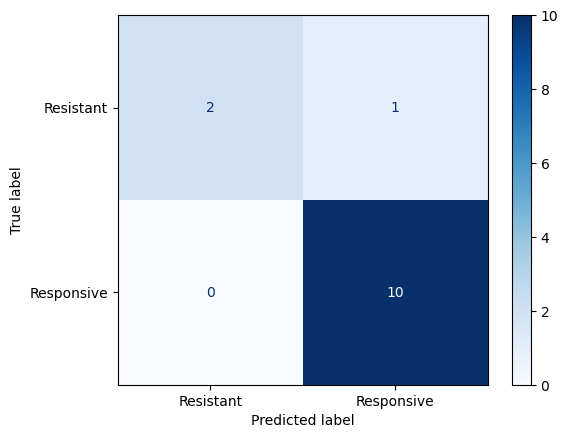

In [447]:
# Predict on mRNA validation set
val_preds_mrna = final_model_mrna.predict(X_val_mrna)

# Print accuracy and classification report
print("Validation Accuracy (mRNA):", accuracy_score(y_val_mrna, val_preds_mrna))
print("\nClassification Report (mRNA):\n", classification_report(y_val_mrna, val_preds_mrna))

# Generate and display confusion matrix
cm_mrna = confusion_matrix(y_val_mrna, val_preds_mrna)
disp_mrna = ConfusionMatrixDisplay(confusion_matrix=cm_mrna, display_labels=final_model_mrna.classes_)
disp_mrna.plot(cmap='Blues', values_format='d')


In [ ]:
# Predict on mRNA test set
test_preds_mrna = final_model_mrna.predict(X_test_mrna)

# Print accuracy and classification report
print("Test Accuracy (mRNA):", accuracy_score(y_test_mrna, test_preds_mrna))
print("\nClassification Report (mRNA):\n", classification_report(y_test_mrna, test_preds_mrna))

# Generate and display confusion matrix
cm_test_mrna = confusion_matrix(y_test_mrna, test_preds_mrna)
disp_test_mrna = ConfusionMatrixDisplay(confusion_matrix=cm_test_mrna, display_labels=final_model_mrna.classes_)
disp_test_mrna.plot(cmap='Blues', values_format='d')


Test AUC (mRNA): 0.85


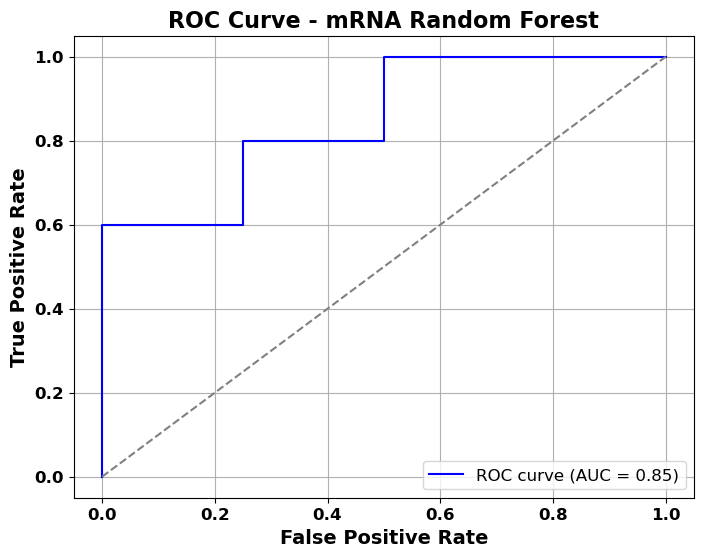

In [452]:

# Get predicted probabilities for the positive class
# Assuming 'Responsive' is the positive class; adjust if needed
y_prob_mrna = final_model_mrna.predict_proba(X_test_mrna)[:, 1]

# Compute AUC
auc_score_mrna = roc_auc_score(y_test_mrna, y_prob_mrna)
print("Test AUC (mRNA):", auc_score_mrna)

# Compute ROC curve
fpr_mrna, tpr_mrna, thresholds_mrna = roc_curve(y_test_mrna, y_prob_mrna, pos_label='Responsive')

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_mrna, tpr_mrna, color='blue', label=f'ROC curve (AUC = {auc_score_mrna:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Bold and black tick labels
plt.xticks(fontsize=12, fontweight='bold', color='black')
plt.yticks(fontsize=12, fontweight='bold', color='black')

plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', color='black')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', color='black')
plt.title('ROC Curve - mRNA Random Forest', fontsize=16, fontweight='bold', color='black')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

## CNA

In [458]:
def wrangler_cna(data):
    """
    Cleans the merged DataFrame for ML:
    - Drops rows with missing MEASURE_OF_RESPONSE
    - Maps MEASURE_OF_RESPONSE into 'Responsive' and 'Resistant'
    - Drops ID columns (PATIENT_ID, Sample_ID_x, Sample_ID_y)
    - Retains only columns ending with 'cna' (CNV features) plus MEASURE_OF_RESPONSE
    - Resets index to avoid misalignment issues
    Returns the cleaned DataFrame ready for training.
    """

    # Drop rows with missing response
    data = data.dropna(subset=['MEASURE_OF_RESPONSE']).copy()

    # Map to binary response classes
    response_map = {
        'complete response': 'Responsive',
        'partial response': 'Responsive',
        'stable disease': 'Resistant',
        'clinical progressive disease': 'Resistant',
        'radiographic progressive disease': 'Resistant'
    }
    data['MEASURE_OF_RESPONSE'] = data['MEASURE_OF_RESPONSE'].replace(response_map)

    # Drop ID columns if present
    id_cols_to_drop = [col for col in ['PATIENT_ID', 'Sample_ID_x', 'Sample_ID_y'] if col in data.columns]
    data = data.drop(columns=id_cols_to_drop)

    # Keep only CNV features and target
    cna_cols_to_keep = [col for col in data.columns if col.lower().endswith('cna')]
    data = data[cna_cols_to_keep + ['MEASURE_OF_RESPONSE']]

    # Reset index
    data.reset_index(drop=True, inplace=True)

    print(f"Cleaned CNV data shape: {data.shape}")
    print("Response class counts:\n", data['MEASURE_OF_RESPONSE'].value_counts())

    return data

# Clean the data using wrangler function
df_cna = wrangler_cna(df_clean)

# Display the shape of the cleaned DataFrame
print("Cleaned DataFrame shape:", df_cna.shape)

# Preview the first few rows
df_cna.head()

cna_copy=df_cna.copy()
cna_copy.to_csv('cna_copy.csv', index=False)
print("Saved cna_copy.csv")

Cleaned CNV data shape: (131, 14)
Response class counts:
 MEASURE_OF_RESPONSE
Responsive    98
Resistant     33
Name: count, dtype: int64
Cleaned DataFrame shape: (131, 14)
Saved cna_copy.csv


### CNA Statistical Analysis

C:\Users\peace\AppData\Local\Temp\ipykernel_22808\266757201.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


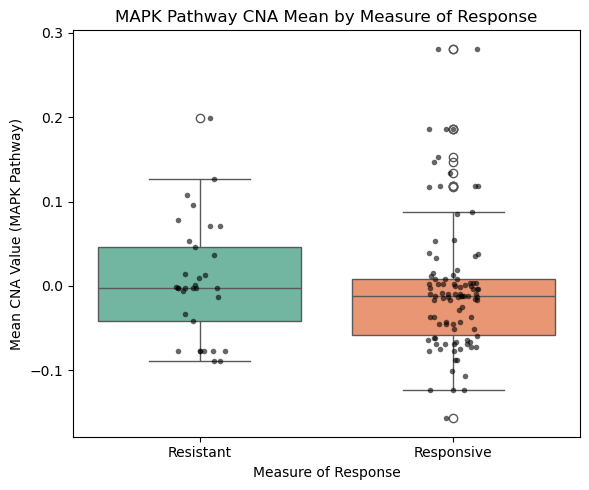

Mann–Whitney U test (CNA) between 'Resistant' and 'Responsive':
  Group 1 mean = 0.005, median = -0.002, n = 33
  Group 2 mean = -0.003, median = -0.012, n = 98
  U = 1798.500, p = 3.371e-01


In [460]:
# Define CNA genes (MAPK pathway) with correct suffix
genes_cna = ['ARAF_CNA', 'BRAF_CNA', 'CNKSR2_CNA', 'EGFR_CNA', 'HRAS_CNA',
       'KRAS_CNA', 'KSR1_CNA', 'MAP2K1_CNA', 'MAP2K2_CNA', 'MAPK1_CNA',
       'MAPK3_CNA', 'NRAS_CNA', 'RAF1_CNA']
# Keep only numeric CNA columns
numeric_cna_cols = [g for g in genes_cna if pd.api.types.is_numeric_dtype(cna_copy[g])]

# Calculate row-wise mean CNA for MAPK pathway
cna_copy["MAPK_CNA_mean"] = cna_copy[numeric_cna_cols].mean(axis=1)

# Boxplot + stripplot comparison
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=cna_copy,
    x="MEASURE_OF_RESPONSE",
    y="MAPK_CNA_mean",
    palette="Set2"
)
sns.stripplot(
    data=cna_copy,
    x="MEASURE_OF_RESPONSE",
    y="MAPK_CNA_mean",
    color="black",
    size=4,
    jitter=True,
    alpha=0.6
)
plt.title("MAPK Pathway CNA Mean by Measure of Response")
plt.xlabel("Measure of Response")
plt.ylabel("Mean CNA Value (MAPK Pathway)")
plt.tight_layout()
plt.show()

# Statistical comparison if exactly two groups exist
if cna_copy["MEASURE_OF_RESPONSE"].nunique() == 2:
    # Ensure consistent ordering
    categories_cna = sorted(cna_copy["MEASURE_OF_RESPONSE"].unique())
    group_cna1_label, group_cna2_label = categories_cna

    group_cna1 = cna_copy.loc[cna_copy["MEASURE_OF_RESPONSE"] == group_cna1_label, "MAPK_CNA_mean"]
    group_cna2 = cna_copy.loc[cna_copy["MEASURE_OF_RESPONSE"] == group_cna2_label, "MAPK_CNA_mean"]

    # Mann–Whitney U test (non-parametric)
    u_stat_cna, p_val_cna = mannwhitneyu(group_cna1, group_cna2, alternative='two-sided')

    print(f"Mann–Whitney U test (CNA) between '{group_cna1_label}' and '{group_cna2_label}':")
    print(f"  Group 1 mean = {group_cna1.mean():.3f}, median = {group_cna1.median():.3f}, n = {len(group_cna1)}")
    print(f"  Group 2 mean = {group_cna2.mean():.3f}, median = {group_cna2.median():.3f}, n = {len(group_cna2)}")
    print(f"  U = {u_stat_cna:.3f}, p = {p_val_cna:.3e}")


In [470]:
# Column name for CNA values
cna_col = "MAPK_CNA_mean"

# Overall normality check
stat, p = shapiro(cna_copy[cna_col].dropna())
print(f"Shapiro-Wilk test for {cna_col} overall: stat={stat:.3f}, p={p:.3e}")
print("Result:", "Normal distribution (fail to reject H0)" if p > 0.05 else "Not normal (reject H0)")
print("-" * 60)

# Normality check within each response group
for category in cna_copy['MEASURE_OF_RESPONSE'].dropna().unique():
    group_data = cna_copy.loc[cna_copy['MEASURE_OF_RESPONSE'] == category, cna_col].dropna()

    if len(group_data) < 3:
        print(f"Skipping '{category}': not enough data for Shapiro-Wilk test.")
        continue

    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {cna_col} in '{category}': stat={stat:.3f}, p={p:.3e}")
    print("Result:", "Normal distribution (fail to reject H0)" if p > 0.05 else "Not normal (reject H0)")
    print("-" * 60)

Shapiro-Wilk test for MAPK_CNA_mean overall: stat=0.905, p=1.305e-07
Result: Not normal (reject H0)
------------------------------------------------------------
Shapiro-Wilk test for MAPK_CNA_mean in 'Resistant': stat=0.930, p=3.535e-02
Result: Not normal (reject H0)
------------------------------------------------------------
Shapiro-Wilk test for MAPK_CNA_mean in 'Responsive': stat=0.882, p=2.670e-07
Result: Not normal (reject H0)
------------------------------------------------------------


In [ ]:
cna_col = "MAPK_CNA_mean"

# Get unique response categories (assuming only 2 groups)
groups = cna_copy['MEASURE_OF_RESPONSE'].dropna().unique()
if len(groups) != 2:
    raise ValueError(f"Cohen's d works best with 2 groups, found {len(groups)} groups.")

group1 = cna_copy.loc[cna_copy['MEASURE_OF_RESPONSE'] == groups[0], cna_col].dropna()
group2 = cna_copy.loc[cna_copy['MEASURE_OF_RESPONSE'] == groups[1], cna_col].dropna()

# Means and std deviations
mean1, mean2 = group1.mean(), group2.mean()
std1, std2 = group1.std(ddof=1), group2.std(ddof=1)
n1, n2 = len(group1), len(group2)

# Pooled standard deviation
pooled_sd = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1 + n2 - 2))

# Cohen's d
cohens_d = (mean1 - mean2) / pooled_sd

# Hedges' g correction factor
correction_factor = 1 - (3 / (4*(n1 + n2) - 9))
hedges_g = cohens_d * correction_factor

# Rank-biserial correlation via Mann–Whitney U
U_stat, _ = mannwhitneyu(group1, group2, alternative='two-sided')
rank_biserial = 1 - (2 * U_stat) / (n1 * n2)

print(f"Cohen's d: {cohens_d:.4f}")
print(f"Hedges' g: {hedges_g:.4f}")
print(f"Rank-biserial correlation: {rank_biserial:.4f}")
print(f"Group 1 ({groups[0]}): mean={mean1:.4f}, n={n1}")
print(f"Group 2 ({groups[1]}): mean={mean2:.4f}, n={n2}")
